In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import plotly
from plotly import graph_objs 
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)


import nbconvert
import seaborn as sns

from sklearn.model_selection import train_test_split

import string
import nltk
from nltk.corpus import stopwords

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

from utils2 import *

In [2]:
df = pd.read_csv('balanced_data_combined.csv')
df.head()

,Unnamed: 0,text,class
0,0,Drasko they didn't cook half a bird you idiot ...,1
1,1,Hopefully someone cooks Drasko in the next ep ...,1
2,2,of course you were born in serbia...you're as ...,1
3,3,These girls are the equivalent of the irritati...,1
4,4,RT @YesYoureRacist: At least you're only a tin...,1


In [3]:
df['class'].value_counts()

class
1    4174
0    4163
Name: count, dtype: int64

In [4]:
hate = len(df[df['class']==1])
not_hate = len(df[df['class']==0])

print(f'hate : {hate} , not_hate : {not_hate}')

dist = [graph_objs.Bar(
    x=['hate','not_hate'],
    y=[hate, not_hate],
)]
plotly.offline.iplot({'data': dist, 'layout': graph_objs.Layout(title='Class Distribution Visualisation')})

hate : 4174 , not_hate : 4163


In [5]:
df = df.drop('Unnamed: 0', axis = 1)
df.dropna(subset=['text'], inplace=True)

In [6]:
df = df.rename(columns={'text': 'tweet', 'class': 'target'})
df.head()

,tweet,target
0,Drasko they didn't cook half a bird you idiot ...,1
1,Hopefully someone cooks Drasko in the next ep ...,1
2,of course you were born in serbia...you're as ...,1
3,These girls are the equivalent of the irritati...,1
4,RT @YesYoureRacist: At least you're only a tin...,1


In [45]:
X = df.tweet
y = df.target
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
train_X = train_X.to_list()
test_X = test_X.to_list()

train_y = train_y.to_numpy()
train_y = train_y.reshape((train_y.shape[0],1))
test_y = test_y.to_numpy()
test_y = test_y.reshape((test_y.shape[0],1))

In [15]:
print(train_y.shape)

(6668, 1)


In [16]:
print(len(train_X))

6668


In [47]:
print(f'train_x[5] : {train_X[5]}')
print(f'train_y[5] : {train_y[5]}')

train_x[5] : Do you have a nickname? What is it? &#8212; Tator, Tator tot, Tightey whitey, whitey Jr, Taylor whitey pants, agent ti... http://t.co/xLBhDJfBF4
train_y[5] : [0]


In [48]:
type(train_X)

list

In [49]:
freqs = build_freqs(train_X, train_y)

# check the output
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))

type(freqs) = <class 'dict'>
len(freqs) = 12522


In [50]:
def predict_tweet(tweet, freqs, theta):
    '''
    Input: 
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output: 
        y_pred: the probability of a tweet being positive or negative
    '''
    
    
    # extract the features of the tweet and store it into x
    x = extract_features(tweet,freqs)
    
    # make the prediction using x and theta
    y_pred = sigmoid(np.dot(x,theta))
    
    
    
    return y_pred

In [51]:
from sklearn.metrics import confusion_matrix

In [52]:
def test_logistic_regression(test_x, test_y, freqs, theta, predict_tweet=predict_tweet):
    """
    Input: 
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
    Output: 
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """
    
    
    
    # the list for storing predictions
    y_hat = []
    
    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, theta)
        
        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1.0)
        else:
            # append 0 to the list
            y_hat.append(0.0)

    # With the above implementation, y_hat is a list, but test_y is (m,1) array
    # convert both to one-dimensional arrays in order to compare them using the '==' operator
    test_y = np.squeeze(test_y).tolist()
    y_hat = np.asarray(y_hat)
    accuracy = np.sum(test_y==y_hat)/len(test_y)
    cm = confusion_matrix(test_y, y_hat)
    tn, fp, fn, tp = confusion_matrix(test_y, y_hat).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = tp/(tp+((fp+fn)/2))

    

    
    
    return accuracy, cm, precision, recall, f1

In [53]:
# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(train_X), 3))
for i in range(len(train_X)):
    X[i, :]= extract_features(train_X[i], freqs)

# training labels corresponding to X
Y = train_y

# Apply gradient descent
J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 1000000)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

The cost after training is 0.34366633.
The resulting vector of weights is [-2.29e-05, 0.00652385, -0.0089233]


In [54]:
tmp_accuracy, cm, precision, recall, f1 = test_logistic_regression(test_X, test_y, freqs, theta)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")
print(f"Logistic regression model's precision = {precision:.4f}")
print(f"Logistic regression model's recall = {recall:.4f}")
print(f"Logistic regression model's f1 score = {f1:.4f}")
cm

Logistic regression model's accuracy = 0.8698
Logistic regression model's precision = 0.8758
Logistic regression model's recall = 0.8621
Logistic regression model's f1 score = 0.8689


array([[731, 102],
       [115, 719]])

In [36]:
my_tweet = "this is such a sweet move"
print(process_tweet(my_tweet))
y_hat = predict_tweet(my_tweet, freqs, theta)
print(y_hat)
if y_hat > 0.5:
    print('Hate Speech')
else: 
    print('Not hate speech')

['sweet', 'move']
[[0.47524273]]
Not hate speech


Text(45.722222222222214, 0.5, 'Observed')

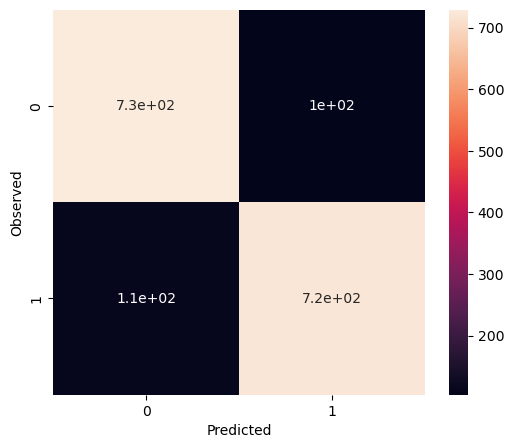

In [31]:
import seaborn as sn
plt.figure(figsize=(6,5))
sn.heatmap(cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Observed')

### Testing the model on original dataset

In [37]:
df_test = pd.read_csv('labeled_data.csv')

In [38]:
df_test.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [40]:
df_test['class'] = df_test['class'].replace(2,1)
df_test['class'] = df_test['class'].replace([0,1],[1,0])

In [41]:
df_test['class'].value_counts()

class
0    23353
1     1430
Name: count, dtype: int64

In [42]:
test_X = df_test.tweet
test_y = df_test['class']

test_X = test_X.to_list()


test_y = test_y.to_numpy()
test_y = test_y.reshape((test_y.shape[0],1))

In [43]:
tmp_accuracy, cm, precision, recall, f1 = test_logistic_regression(test_X, test_y, freqs, theta)

In [44]:
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")
print(f"Logistic regression model's precision = {precision:.4f}")
print(f"Logistic regression model's recall = {recall:.4f}")
print(f"Logistic regression model's f1 score = {f1:.4f}")
cm

Logistic regression model's accuracy = 0.3224
Logistic regression model's precision = 0.0630
Logistic regression model's recall = 0.7741
Logistic regression model's f1 score = 0.1165


array([[ 6883, 16470],
       [  323,  1107]])